In [104]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

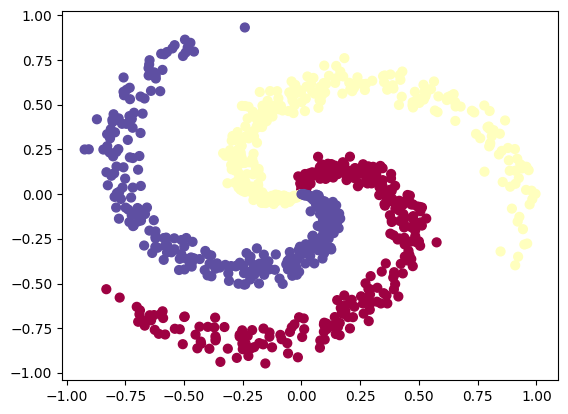

<Figure size 640x480 with 0 Axes>

In [105]:
N = 300 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()
plt.savefig('temp.png', dpi=600)

In [106]:
print(X.shape)
print(y.shape)
print(X[ :10, : ])
print(y[ :10])

(900, 2)
(900,)
[[ 0.          0.        ]
 [ 0.00023379  0.0033363 ]
 [ 0.00042033  0.00667574]
 [-0.00047659  0.01002212]
 [ 0.00224457  0.01318828]
 [ 0.00222217  0.0165741 ]
 [-0.00157444  0.02000503]
 [ 0.00014924  0.0234109 ]
 [ 0.00862662  0.025327  ]
 [ 0.00314158  0.02993594]]
[0 0 0 0 0 0 0 0 0 0]


In [107]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
X_train = torch.from_numpy(X_train).type(torch.float32)
y_train = torch.from_numpy(y_train).type(torch.float32)
X_test = torch.from_numpy(X_test).type(torch.float32)
y_test = torch.from_numpy(y_test).type(torch.float32)

In [108]:
class ClassificationSpiral(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.layer1 = torch.nn.Linear(in_features=2, out_features=10)
        self.layer2 = torch.nn.Linear(in_features=10, out_features=10)
        self.layer3 = torch.nn.Bilinear(in1_features=10, in2_features=10 ,out_features=10)
        self.layer4 = torch.nn.Linear(in_features=10, out_features=num_classes)
        self.relu = torch.nn.ReLU()

    def forward(self, X):
       return self.layer4(self.relu(self.layer3(self.relu(self.layer2(self.relu(self.layer1(X)))))))
   
model_spiral = ClassificationSpiral()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_spiral.parameters(), lr=0.1)

TypeError: Bilinear.__init__() got an unexpected keyword argument 'in_features'

In [89]:
def cal_accuracy(y_test, y_pred):
    a = torch.eq(y_pred, y_test).sum().item()
    return a/len(y_pred)*100

In [90]:
logits = model_spiral(X_train[0:5, : ])
predictions = torch.argmax(logits, dim=1)
for i in range(5):
    print(f"X: {X_train[i]}, Y: {y_train[i]}, logit: {logits[i]}, prediction: {predictions[i]}")

X: tensor([-0.0659, -0.2834]), Y: 2.0, logit: tensor([ 0.1230, -0.0843,  0.2477], grad_fn=<SelectBackward0>), prediction: 2
X: tensor([ 0.0068, -0.3511]), Y: 2.0, logit: tensor([ 0.1262, -0.0788,  0.2538], grad_fn=<SelectBackward0>), prediction: 2
X: tensor([-0.6448, -0.7512]), Y: 0.0, logit: tensor([ 0.1308, -0.0557,  0.2368], grad_fn=<SelectBackward0>), prediction: 2
X: tensor([ 0.3920, -0.4210]), Y: 0.0, logit: tensor([ 0.1303, -0.0629,  0.2652], grad_fn=<SelectBackward0>), prediction: 2
X: tensor([-0.7713,  0.4228]), Y: 2.0, logit: tensor([ 0.1249, -0.1455,  0.1664], grad_fn=<SelectBackward0>), prediction: 2


In [98]:
epochs=1000
train_loss_list=[]
test_loss_list=[]

for epoch in range(epochs):
   model_spiral.train()

   #foreard_pass
   y_train = y_train.long()
   train_logits=model_spiral(X_train)
   train_loss=loss_func(train_logits, y_train)
   train_predictions = torch.argmax(train_logits, dim=1)
   train_accuracy = cal_accuracy(train_predictions, y_train)

   optimizer.zero_grad()

   #backward pass
   train_loss.backward()
   optimizer.step()

   model_spiral.eval()
   with torch.inference_mode():
      y_test = y_test.long()
      test_logits=model_spiral(X_test)
      test_loss=loss_func(test_logits, y_test)
      test_predictions=torch.argmax(test_logits, dim=1)
      test_accuracy=cal_accuracy(y_test, test_predictions)

      if epoch%100 == 0:
         print(f"Epoch: {epoch}, Train_Loss: {train_loss:.4f}, Train_accuracy: {train_accuracy:.2f}%, Test_Loss: {test_loss:.4f}, Test_accuracy: {test_accuracy:.2f}%")

Epoch: 0, Train_Loss: 1.0061, Train_accuracy: 64.92%, Test_Loss: 1.0111, Test_accuracy: 57.78%
Epoch: 100, Train_Loss: 0.7922, Train_accuracy: 58.25%, Test_Loss: 0.7989, Test_accuracy: 54.81%
Epoch: 200, Train_Loss: 0.6905, Train_accuracy: 59.84%, Test_Loss: 0.7109, Test_accuracy: 54.07%
Epoch: 300, Train_Loss: 0.6449, Train_accuracy: 62.54%, Test_Loss: 0.6656, Test_accuracy: 57.78%
Epoch: 400, Train_Loss: 0.5974, Train_accuracy: 66.83%, Test_Loss: 0.6140, Test_accuracy: 61.11%
Epoch: 500, Train_Loss: 0.5471, Train_accuracy: 69.52%, Test_Loss: 0.5578, Test_accuracy: 65.93%
Epoch: 600, Train_Loss: 0.4977, Train_accuracy: 72.38%, Test_Loss: 0.5017, Test_accuracy: 72.22%
Epoch: 700, Train_Loss: 0.4509, Train_accuracy: 76.51%, Test_Loss: 0.4504, Test_accuracy: 77.04%
Epoch: 800, Train_Loss: 0.4069, Train_accuracy: 78.89%, Test_Loss: 0.4044, Test_accuracy: 81.85%
Epoch: 900, Train_Loss: 0.3619, Train_accuracy: 82.54%, Test_Loss: 0.3590, Test_accuracy: 85.56%
